In [1]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, box
from matplotlib.patches import FancyBboxPatch, BoxStyle
#import re
from matplotlib.path import Path

read_smaller_states = True

# #these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {
                    'VA': {},
            }

g = 0
scale = 20
map_buffer_ratio = .1
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "

equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
absolute_overlap_tol = 100    # tolerance for declaring areas overlapping, in sq meters
desired_pct_area_overlap = 0.5     # relative overlap to declare something a match

show_water = True
show_roads = False



water_area_tol = .5 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [3]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [4]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [5]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [6]:
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
#state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('STATE_NAME')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('STATE').sort_index()

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

for this_state in these_states_dict.keys():
    these_states_dict[this_state]['STATEFP'] = state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]    
    these_states_dict[this_state]['seats_old'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_old'].values[0]
    these_states_dict[this_state]['seats_new'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_new'].values[0]
#pprint(these_states_dict)
print('\n')
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))



looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!


Got old and new numbers of districts for 1 focus states in 0.0 seconds!


# Read summary levels

In [7]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.1 seconds!


# Read redistricting geo data

In [8]:
s = time.time()
print('reading redistricting geography data for all states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

# geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
# geo_df.set_index('SUMLEV')
# print('adding summary level descriptions...')
# geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
# geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for all states...
	reading vageo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 242,095 geographies in 0 minutes 9 seconds!


In [9]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.1 seconds!


In [10]:
s = time.time()
print('Getting current Congressional District data...')
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


Getting current Congressional District data...
adding shapefiles...


Joined 11 congressional districts to shapefiles in 3.3 seconds!


In [11]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state))
    #print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')


#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for VA...


Joined 2,198 tracts to shapefiles in 11.2 seconds!


In [12]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [13]:
s = time.time()
this_state = 'VA'

state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
#state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'COUNTYNS'] = pandas.to_numeric(county_gdf['COUNTYNS'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
#county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()

    for i in range(0, len(waterfiles)):
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf.loc[:, 'MEMI'] = pandas.to_numeric(cbsa_gdf['MEMI'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

print('\tFinding populations of CBSAs...')
cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
for ix, thisrow in cbsa_gdf.sort_values(by='NAME').iterrows():
    cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
    if (this_state in thisrow['NAME']):
        print('\t\t{0:} (n = {1:,.0f})...'.format(thisrow['NAME'], cbsa_gdf.loc[ix]['POP100']))
cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(place_gdf['STATEFP'])
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,1) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')


cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x)][['NAME', 'POP100']].sort_values(by='POP100', ascending=False)


getting states...
getting counties...
Got 56 states and 3,234 counties in 6.2 seconds!


getting water areas...
	reading water file 0 of 133...
	reading water file 10 of 133...
	reading water file 20 of 133...
	reading water file 30 of 133...
	reading water file 40 of 133...
	reading water file 50 of 133...
	reading water file 60 of 133...
	reading water file 70 of 133...
	reading water file 80 of 133...
	reading water file 90 of 133...
	reading water file 100 of 133...
	reading water file 110 of 133...
	reading water file 120 of 133...
	reading water file 130 of 133...
Got 708 water areas in 0 minutes 24.6 seconds!


getting CBSAs (metro areas)...
	Finding populations of CBSAs...
		Big Stone Gap, VA (n = 39,817)...
		Blacksburg-Christiansburg, VA (n = 166,378)...
		Bluefield, WV-VA (n = 46,699)...
		Charlottesville, VA (n = 221,524)...
		Danville, VA (n = 103,091)...
		Harrisonburg, VA (n = 135,571)...
		Kingsport-Bristol, TN-VA (n = 92,730)...
		Lynchburg, VA (n = 261,593)...
		Marti

,NAME,POP100
GEOID,,
47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",3077537.0
47260,"Virginia Beach-Norfolk-Newport News, VA-NC",1750741.0
40060,"Richmond, VA",1314434.0
40220,"Roanoke, VA",315251.0
31340,"Lynchburg, VA",261593.0
16820,"Charlottesville, VA",221524.0
13980,"Blacksburg-Christiansburg, VA",166378.0
25500,"Harrisonburg, VA",135571.0
44420,"Staunton, VA",125433.0


In [14]:

# s = time.time()
# print('setting up insets...')
# insets = {}

# insets['se'] = {}
# insets['se']['how'] = 'districts'
# insets['se']['bounds'] = [-80.48, 25.54, -80, 26.84]
# insets['se']['axes_position'] = [0.3, 0.01]
# insets['se']['axes_rel_size'] = .255
# insets['se']['districts'] = [21,22,23,24,27]
# insets['se']['partial_districts'] = [18,20,25,26]
# insets['se']['counties'] = ['Palm Beach County', 'Broward County', 'Miami-Dade County']
# insets['se']['title'] = 'Southeast Florida'
# insets['se']['titlesize'] = 22
# insets['se']['borderwidth'] = 3

# insets['tpa'] = {}
# insets['tpa']['how'] = 'districts'
# #insets['tpa']['bounds'] = [-82.85, 27.6, -82, 28.2]
# insets['tpa']['bounds'] = [-82.9, 27.6, -82.18, 28.2]
# insets['tpa']['axes_position'] = [0.03, 0.015]
# insets['tpa']['axes_rel_size'] = 0.255
# insets['tpa']['districts'] = [13,14]
# insets['tpa']['partial_districts'] = [12, 15, 16]
# insets['tpa']['counties'] = ['Hillsborough County', 'Pinellas County']
# insets['tpa']['title'] = 'Tampa Bay'
# insets['tpa']['titlesize'] = 22
# insets['tpa']['borderwidth'] = 3

# insets['orl'] = {}
# insets['orl']['how'] = 'counties'
# insets['orl']['bounds'] = [-81.68, 28.33, -80.82, 28.88]

# insets['orl']['axes_position'] = [0.03, 0.26]
# insets['orl']['axes_rel_size'] = 0.255
# insets['orl']['districts'] = [7,10]
# insets['orl']['partial_districts'] = [6,8,9,11,15]
# insets['orl']['counties'] = ['Orange County', 'Seminole County']
# insets['orl']['title'] = 'Orlando'
# insets['orl']['titlesize'] = 22
# insets['orl']['borderwidth'] = 3

# insets['jax'] = {}
# insets['jax']['how'] = 'counties'
# insets['jax']['axes_position'] = [0.84, 0.87]
# insets['jax']['axes_rel_size'] = 0.15
# insets['jax']['districts'] = [4,5]
# insets['jax']['partial_districts'] = [3]
# insets['jax']['counties'] = ['Duval County']
# insets['jax']['title'] = 'Jacksonville'
# insets['jax']['titlesize'] = 22
# insets['jax']['borderwidth'] = 3

# insets['tally'] = {}
# insets['tally']['how'] = 'places'
# insets['tally']['axes_position'] = [0.84, 0.69]
# insets['tally']['axes_rel_size'] = 0.15
# insets['tally']['districts'] = [2,5]
# insets['tally']['partial_districts'] = []
# insets['tally']['counties'] = ['Leon County']
# insets['tally']['places'] = ['Tallahassee']
# insets['tally']['title'] = 'Tallahassee'
# insets['tally']['titlesize'] = 22
# insets['tally']['borderwidth'] = 3


# for inset_name, inset in insets.items():
#     print(inset_name)
    
#     if ('bounds' in inset.keys()):
#         inset['aspect_ratio'] = (inset['bounds'][2] - inset['bounds'][0]) / (inset['bounds'][3] - inset['bounds'][1])
#     else:
#         if (inset['how'] == 'districts'):
#             thegeo = unary_union(cd_gdf[cd_gdf['CD116'].isin(inset['districts'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'counties'):
#             thegeo = unary_union(tract_gdf[tract_gdf['COUNTY_NAME'].isin(inset['counties'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'places'):
#             thegeo = unary_union(place_gdf[place_gdf['NAME'].isin(inset['places'])].geometry.tolist()).bounds
#         xlims = [thegeo[0], thegeo[2]]
#         ylims = [thegeo[1], thegeo[3]]        
#         xspan = xlims[1] - xlims[0]
#         yspan = ylims[1] - ylims[0]
#         inset['aspect_ratio'] = xspan / yspan
#         xlims[0] = xlims[0] - (map_buffer_ratio * xspan)
#         ylims[0] = ylims[0] - (map_buffer_ratio * yspan)
#         xlims[1] = xlims[1] + (map_buffer_ratio * xspan)
#         ylims[1] = ylims[1] + (map_buffer_ratio * yspan)    
#         inset['bounds'] = [xlims[0], ylims[0], xlims[1], ylims[1]]
#         print(inset['bounds'])
    
#     inset['box_gdf'] = geopandas.GeoDataFrame(data=[[
#         box(
#             inset['bounds'][0], 
#             inset['bounds'][1], 
#             inset['bounds'][2], 
#             inset['bounds'][3]
#         )]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')    
#     inset['axes_size'] = [inset['axes_rel_size'], inset['axes_rel_size'] / inset['aspect_ratio']]
# #    print(inset['axes_size'])

# all_inset_districts = []
# for inset in insets.values():
#     all_inset_districts += inset['districts']
# main_map_districts = [x for x in list(range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1)) if x not in all_inset_districts]

# main_map_districts += [x for x in insets['jax']['districts']]
# main_map_districts += [x for x in insets['tally']['districts']]
# main_map_districts = sorted(main_map_districts)

# #print(main_map_districts)
# e = time.time()
# g += (e-s)
# print('Done!')
# #main_map_districts


main map...
	reprojecting...
	plotting...
		Plotting VA...
	plotting census tracts...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...
Done plotting in 29 seconds!


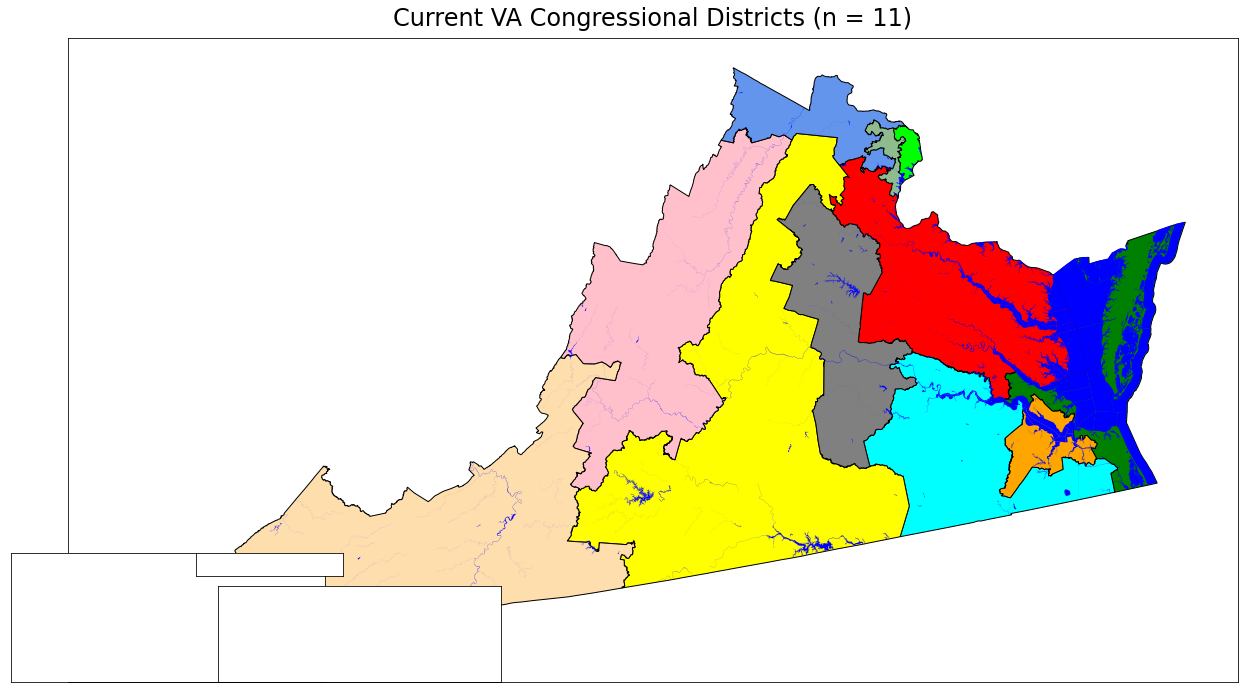

In [15]:
s = time.time()
# main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
# alaska_crs = "epsg:3338"
# hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = True

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].tolist():#.sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    cdlist = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(cdlist)+1):
        cd_gdf[
            (cd_gdf['STUSAB'] == this_state) 
            & (cd_gdf['CD116'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
#         annotator = i
#         this_district_geo = unary_union(cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == i)].to_crs(main_map_crs).geometry.tolist())
#         centerpoint = (this_district_geo.centroid.x, this_district_geo.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
# #ax.legend(handles=legend_list, fontsize=10)


if (len(list(these_states_dict.keys())) == 1):
    ax.set_title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
    ), fontsize=24, y=1.01)
else:
    ax.set_title('Current Congressional Districts', fontsize=24, y=1.01)

# # # # ax.tick_params(axis='both', labelsize=20)

# # # # # print('saving figure...')
# # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # #plt.show()
# # e = time.time()
# # g += (e-s)
# # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'AK']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'HI']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'HI') & (cd_gdf['CD116'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

for thisax in [ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

# print('saving figure...')
# fig.savefig(script_dir+'all-districts-orig.jpg', format='jpg', dpi=300, bbox_inches='tight')
#plt.show()
e = time.time()
g += (e-s)
print('Done plotting in {0:,.0f} seconds!'.format(e-s))

# How many districts in each state?

In [16]:
for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        these_states_dict[this_state_name]['target'] = -1
    else:
        these_states_dict[this_state_name]['target'] = cd_gdf[cd_gdf['STUSAB'] == this_state_name]['POP100'].sum() / this_state['seats_new']
    
    
these_states_dict
#water_gdf.head(1).T

{'VA': {'STATEFP': 51,
  'seats_old': 11,
  'seats_new': 11,
  'target': 784672.0909090909}}

# VIRGINIA

In [94]:
s = time.time()

this_state = 'VA'
examine_duplicates = True

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

#print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[ 
['Surry County',2],
     
    
['Richmond city',7],
    ['Henrico County',7],


    
['Roanoke city',6],    
    ['Salem city',6],    
    ['Lynchburg city',6],    
    ['Bedford County',6],    
    ['Charlottesville city',6],    
    ['Albemarle County',6],    
    ['Nelson County',6],    
    ['Amherst County',6],    
    ['Staunton city',6],    
    ['Waynesboro city',6],    
    ['Lexington city',6],   
    ['Buena Vista city',6],   
    ['Campbell County',6], 
    ['Appomattox County',6], 



['Southampton County',4],
    ['Sussex County',4],
    ['Greensville County',4],
    ['Emporia city',4],
    ['Petersburg city',4],
    ['Hopewell city',4],
    ['Colonial Heights city',4],
    ['Dinwiddie County',4],
    ['Mecklenburg County',4],
    ['Lunenburg County',4],
    ['Brunswick County',4],
    ['Charlotte County',4],
    ['Halifax County',4],
    ['Pittsylvania County',4],
    ['Danville city',4],
    ['Nottoway County',4],
    ['Amelia County',4],
    ['Prince Edward County',4],
    ['Cumberland County',4],
    ['Powhatan County',4],
    ['Buckingham County',4],
    ['Fluvanna County',4],
    ['Goochland County',4],
    

    
['Craig County',9],
    ['Giles County',9],
    ['Montgomery County',9],
    ['Radford city',9],
    ['Pulaski County',9],
    ['Floyd County',9],
    ['Carroll County',9],
    ['Bland County',9],
    ['Wythe County',9],
    ['Grayson County',9],
    ['Galax city',9],
    ['Smyth County',9],
    ['Tazewell County',9],
    ['Buchanan County',9],
    ['Dickenson County',9],
    ['Wise County',9],
    ['Norton city',9],
    ['Washington County',9],
    ['Russell County',9],
    ['Scott County',9],
    ['Lee County',9],
    ['Bristol city',9],
    ['Patrick County',9],
    ['Henry County',9],
    ['Martinsville city',9],
    ['Franklin County',9],
    ['Alleghany County',9],
    ['Covington city',9],
    ['Bath County',9],
    ['Highland County',9],
    
    
    
    
    
['Fauquier County',5],
    ['Warren County',5],
    ['Clarke County',5],
    ['Frederick County',5],
    ['Winchester city',5],
    ['Stafford County',5],
    ['Fredericksburg city',5],
    ['King George County',5],
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Arlington',8], 
    ['Alexandria',8],
    ['Great Falls',8],
    ["Bailey's Crossroads",8], 
    ['McLean',8], 
    ['Seven Corners',8], 
    ['Lake Barcroft',8], 
    ['Falls Church',8], 
    ['West Falls Church',8],     
    ['Pimmit Hills',8], 
    ['Idylwood',8], 
    ['Tysons',8], 
    ['Dunn Loring',8], 
    ['Vienna',8],
    ['Huntington',8],
    ['Belle Haven',8],
    ['Rose Hill',8],
    ['Groveton',8],
    ['Fort Hunt',8],
    ['Woodlawn',8],
    ['Mount Vernon',8],
    ['Kingstowne',8],
    ['Hayfield',8],
    ['Fort Belvoir',8], 
    
    
    
['Lincolnia',11], 
    ['Annandale',11],
    ['Springfield',11], 
    ['North Springfield',11], 
    ['Woodburn',11], 
    ['Ravensworth',11], 
    ['Kings Park',11], 
    ['Wakefield',11],
    ['Mantua',11], 
    ['Newington',11], 
    ['Newington Forest',11], 
    ['West Springfield',11], 
    ['Burke',11], 
    ['Burke Centre',11], 
    ['Kings Park West',11], 
    ['Long Branch',11],
    ['Fairfax',11], 
    ['Fairfax Station',11], 
    ['Braddock',11], 
    ['George Mason',11], 
    ['Fair Oaks',11], 
    ['Oakton',11], 
    ['Difficult Run',11], 
    ['Reston',11], 
    ['Great Falls Crossing',11],   
    ['Lorton',11], 
    ['Laurel Hill',11], 
    ['Crosspointe',11], 
    ['South Run',11], 
    ['Clifton',11], 
    ['Union Mill',11], 
    ['Centreville',11], 
    ['Fair Lakes',11],
    ['Navy',11], 
    ['Greenbriar',11], 
    ['Chantilly',11], 
    ['Sully Square',11], 
    ['Franklin Farm',11], 
    ['Floris',11], 
    ['McNair',11], 
    ['Hutchison',11], 
    ['Herndon',11], 
    ['Dranesville',11],
    ['Wolf Trap',11],
    ['Merrifield',11], 
    
    
    
['Virginia Beach',3], 
    ['Norfolk',3], 
    
    
['Portsmouth',2], 
    ['Hampton',2], 
    ['Newport News',2], 
    ['Bethel Manor',2], 
    ['Poquoson',2], 
    ['Williamsburg',2],

    
    
['Manassas',10], 
    ['Manassas Park',10], 
    ['Buckhall',10], 
    ['Innovation',10], 
    ['Sudley',10], 
    ['Bull Run',10], 
    ['Yorkshire',10], 
    ['Loch Lomond',10],
    ['Linton Hall',10], 
    ['Gainesville',10], 
    ['Haymarket',10],
    ['Independent Hill',10], 
    ['Dale City',10], 
    ['Montclair',10], 
    ['Leesylvania',10], 
    ['Woodbridge',10], 
    ['Occoquan',10], 
    ['Lake Ridge',10], 
    ['County Center',10],
    ['Cherry Hill',10], 
    ['Potomac Mills',10], 
    ['South Riding',10], 
    ['Stone Ridge',10], 
    ['Arcola',10], 
    ['Loudoun Valley Estates',10], 
    ['Moorefield',10], 
    ['Broadlands',10], 
    ['Goose Creek Village',10],
    ['Belmont',10], 
    ['Lansdowne',10], 
    ['University Center',10], 
    ['Lowes Island',10], 
    ['Sugarland Run',10], 
    ['Sterling',10], 
    ['Oak Grove',10],
    ['Ashburn',10], 
    ['One Loudoun',10], 
    ['Countryside',10], 
    ['Kincora',10], 
    ['Dulles Town Center',10], 
    ['Cascades',10],
    

['Bon Air',7], 
    ['Manchester',7], 
    ['Rockwood',7], 
    ['Midlothian',7], 
    ['Bensley',7], 
    ['Meadowbrook',7], 
    ['Bellwood',7],
    ['Mechanicsville',7],    
    
    
    
['Fishersville',6], 
    ['Stuarts Draft',6], 
    ['Lyndhurst',6], 
    ['Verona',6], 
    ['Hollins',6], 
    ['Vinton',6], 
    ['Cave Spring',6], 
    


['Spotsylvania Courthouse',5], 
    
], columns=['NAME', 'new_district_by_place'])


#print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('Accounting for known duplicate places...')
keepers = {}
keepers['Belle Haven'] = {'GEOID': '1600000US5105928', 'description': 'overlaps 2 tracts containing 6,851 people'}
keepers['Rose Hill'] = {'GEOID': '1600000US5168880', 'description': 'overlaps 6 tracts containing 22,940 people'}
keepers['Woodlawn'] = {'GEOID': '1600000US5187410', 'description': 'overlaps 4 tracts containing 20,859 people'}
keepers['Wakefield'] = {'GEOID': '1600000US5182371', 'description': 'overlaps 3 tracts containing 14,689 people'}
keepers['Bull Run'] = {'GEOID': '1600000US5111230', 'description': 'overlaps 2 tracts containing 11,024 people'}


for k,v in keepers.items():
    print('\t{0:}: Keeping GEOID = {1:}: {2:}!'.format(k, v['GEOID'], v['description']))
    place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == k) & (place_mapper_gdf.index != v['GEOID'])].index, axis=0)

print('\n')
print('checking for additional duplicate nanes...')
duplicate_place_names = place_mapper_gdf[place_mapper_gdf['NAME'].duplicated()]['NAME'].tolist()
for this_place in duplicate_place_names:
    print('Examining {0:}...'.format(this_place))
    
    for ix, thisrow in place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
        & (place_gdf['NAME'] == this_place)
    ].to_crs(equal_area_crs).iterrows():
        included_tracts = []
        place_area = thisrow.geometry.area
        print('\t{0:} (GEOID = {1:}), place area = {2:,.2f} km^2...'.format(thisrow['NAMELSAD'], ix, place_area / 1000000))
        
        for jx, thatrow in county_gdf[
            (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
            & (county_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
        ].to_crs(equal_area_crs).iterrows():
            if (thatrow.geometry.intersection(thisrow.geometry).area >= absolute_overlap_tol):
                print('\t\t...overlaps with {0:} by {1:,.2f} km^2...'.format(thatrow['NAMELSAD'], thatrow.geometry.intersection(thisrow.geometry).area / 1000000))
                for kx, otherrow in tract_gdf[
                    #(tract_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
                    (tract_gdf['STUSAB'] == this_state)
                    & (tract_gdf['COUNTY_NAME'] == thatrow['NAMELSAD'])
                    & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
                ].to_crs(equal_area_crs).iterrows():
                    tract_area = otherrow.geometry.area
                    overlap_area = otherrow.geometry.intersection(thisrow.geometry).area
                    pct_overlap = overlap_area / tract_area
                    if (pct_overlap >= desired_pct_area_overlap):
                        print('\t\t\tOverlaps {0:.1%} of census tract {1:}...'.format(pct_overlap, otherrow['census_tract']))
                        included_tracts.append(kx)
        print('\t{0:} (GEOID = {1:}) overlaps {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAME'], ix, len(tract_gdf[tract_gdf.index.isin(included_tracts)]), tract_gdf[tract_gdf.index.isin(included_tracts)]['POP100'].sum()))
        print('-------------------------------------')
        print('\n')
        
print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US51059415401', '1400000US51059421500'], 'new_district'] = 8    # N of Mount Vernon
tract_gdf.loc[['1400000US51059421103'], 'new_district'] = 8   # NW Franconia


tract_gdf.loc[['1400000US51059420201', '1400000US51059420202', '1400000US51059421001', '1400000US51059421101', '1400000US51059491000', '1400000US51059491301'], 'new_district'] = 11   # Rest of Franconia
tract_gdf.loc[['1400000US51059416200', '1400000US51059416300', '1400000US51059440504', '1400000US51059491101', '1400000US51059980100', '1400000US51059980200'], 'new_district'] = 11    # Rest of Fairfax County


tract_gdf.loc[['1400000US51059492100'], 'new_district'] = 11   # South-central Fairfax County  ?also maybe 1400000US51059492201?


tract_gdf.loc[['1400000US51550020001', '1400000US51550020002', '1400000US51550020003'], 'new_district'] = 3    # N part of city of Chesapeake
tract_gdf.loc[['1400000US51550020100', '1400000US51550020200', '1400000US51550020300', '1400000US51550020400', '1400000US51550020808', '1400000US51550020809'], 'new_district'] = 3    # N part of city of Chesapeake
tract_gdf.loc[['1400000US51550020600', '1400000US51550020700', '1400000US51550020804', '1400000US51550020805', '1400000US51550020810', '1400000US51550020811', '1400000US51550020812', '1400000US51550020813', '1400000US51550020814'], 'new_district'] = 3    # NE part of city of Chesapeake
tract_gdf.loc[['1400000US51550021103', '1400000US51550021104'], 'new_district'] = 3    # Far S Chesapeake City


tract_gdf.loc[['1400000US51550020905', '1400000US51550020911', '1400000US51550020912'], 'new_district'] = 2    # NE part of city of Chesapeake
tract_gdf.loc[['1400000US51550020903', '1400000US51550020907', '1400000US51550020908', '1400000US51550020909', '1400000US51550020910', '1400000US51550020500'], 'new_district'] = 2    # Rest of the city of Chesapeake
tract_gdf.loc[['1400000US51550021004', '1400000US51550021005', '1400000US51550021009', '1400000US51550021010', '1400000US51550021011', '1400000US51550021012', '1400000US51550021013', '1400000US51550021014', '1400000US51550021015', '1400000US51550021016', '1400000US51550021101'], 'new_district'] = 2    # Rest of the city of Chesapeake
tract_gdf.loc[['1400000US51550021305', '1400000US51550021401', '1400000US51550021402', '1400000US51550021403', '1400000US51550021405', '1400000US51550021406', '1400000US51550021407', '1400000US51550021304'], 'new_district'] = 2    # Rest of the city of Chesapeake
tract_gdf.loc[['1400000US51550021503', '1400000US51550021504', '1400000US51550021505', '1400000US51550021506', '1400000US51550021507', '1400000US51550021602', '1400000US51550021603', '1400000US51550021604', '1400000US51550021605'], 'new_district'] = 2    # Rest of the city of Chesapeake
tract_gdf.loc[['1400000US51800075202', '1400000US51800075203', '1400000US51800075205', '1400000US51800075206', '1400000US51800075207', '1400000US51800075208'], 'new_district'] = 2    # Rest of Suffolk County
tract_gdf.loc[['1400000US51800065100', '1400000US51800065200', '1400000US51800065301', '1400000US51800065302', '1400000US51800065401', '1400000US51800065402', '1400000US51800065500'], 'new_district'] = 2    # Rest of Suffolk County
tract_gdf.loc[['1400000US51800075103', '1400000US51800075104', '1400000US51800075105', '1400000US51800075106', '1400000US51800075103', '1400000US51800075105', '1400000US51800075106'], 'new_district'] = 2    # Rest of Suffolk County
tract_gdf.loc[['1400000US51800075301', '1400000US51800075302', '1400000US51800075401', '1400000US51800075402', '1400000US51800075404', '1400000US51800075405', '1400000US51800075406', '1400000US51800075407', '1400000US51800075502', '1400000US51800075503', '1400000US51800075504', '1400000US51800075601', '1400000US51800075701', '1400000US51800075702'], 'new_district'] = 2    # Rest of Suffolk County
tract_gdf.loc[['1400000US51093280101', '1400000US51093280104', '1400000US51093280105', '1400000US51093280106', '1400000US51093280107', '1400000US51093280108', '1400000US51093280200', '1400000US51093280300'], 'new_district'] = 2    # Rest of Isle of Wight County
tract_gdf.loc[['1400000US51149850400', '1400000US51036600200', '1400000US51036600300'], 'new_district'] = 2    # East Prince George and Charles City Counties
tract_gdf.loc[['1400000US51095080102', '1400000US51095080103', '1400000US51095080104', '1400000US51095080202', '1400000US51095080203', '1400000US51095080205', '1400000US51095080207', '1400000US51095080208', '1400000US51095080209', '1400000US51095080304', '1400000US51095080306', '1400000US51095080307', '1400000US51095080308'], 'new_district'] = 2    # South James City County


tract_gdf.loc[['1400000US51153901219', '1400000US51153901233'], 'new_district'] = 10    # Between Buckhall and Dale City
tract_gdf.loc[['1400000US51153901407', '1400000US51153901418', '1400000US51153901503'], 'new_district'] = 10    # NW Prince William County
tract_gdf.loc[['1400000US51153900301'], 'new_district'] = 10    # Betweeen Laurel Hill and Woodbridge
tract_gdf.loc[['1400000US51153901504', '1400000US51153901505', '1400000US51153901506'], 'new_district'] = 10    # N of Gainesville
tract_gdf.loc[['1400000US51107611813', '1400000US51107980100', '1400000US51107611810'], 'new_district'] = 10    # Southern Loudoun County
tract_gdf.loc[['1400000US51107611026', '1400000US51107611027', '1400000US51107611030', '1400000US51107611032', '1400000US51107611101'], 'new_district'] = 10    # E Loudoun County
tract_gdf.loc[['1400000US51059491000', '1400000US51059491301'], 'new_district'] = 10     # Bull Run (Far SW Fairfax County)
tract_gdf.loc[['1400000US51059492201', '1400000US51059492500'], 'new_district'] = 10     # SE Fairfax County


tract_gdf.loc[['1400000US51041100403'], 'new_district'] = 7      # E Chesterfield County
tract_gdf.loc[['1400000US51041100910', '1400000US51041100922', '1400000US51041100931', '1400000US51041100932'], 'new_district'] = 7      # Between Rockwood and Midlothian
tract_gdf.loc[['1400000US51041100206', '1400000US51041100211', '1400000US51041100212'], 'new_district'] = 7      # Between Meadowbrook and Manchester
tract_gdf.loc[['1400000US51041100812', '1400000US51041100814', '1400000US51041100815', '1400000US51041100816', '1400000US51041100818', '1400000US51041100819', '1400000US51041100820'], 'new_district'] = 7  # Between Bellwood and Rockwood
tract_gdf.loc[['1400000US51041100915', '1400000US51041100926', '1400000US51041100935', '1400000US51041100936'], 'new_district'] = 7      # Between Tuckahoe and Midlothian
tract_gdf.loc[['1400000US51041100919', '1400000US51041100933', '1400000US51041100934'], 'new_district'] = 7  # Between Rockwood and Bremermill
tract_gdf.loc[['1400000US51149850302', '1400000US51036600100'], 'new_district'] = 7  # East Prince George and Charles City Counties


tract_gdf.loc[['1400000US51015070400', '1400000US51015070500', '1400000US51015070603', '1400000US51015070701', '1400000US51015070702', '1400000US51015070900', '1400000US51015071201', '1400000US51015071202', '1400000US51015071000'], 'new_district'] = 6    # E Augusta County
tract_gdf.loc[['1400000US51163930101', '1400000US51163930102', '1400000US51163930400'], 'new_district'] = 6      # E Rockbridge County
tract_gdf.loc[['1400000US51023040200', '1400000US51023040401', '1400000US51023040402', '1400000US51023040501', '1400000US51023040502'], 'new_district'] = 6      # E Rockbridge County
tract_gdf.loc[['1400000US51161030900', '1400000US51161031000', '1400000US51161031201', '1400000US51161031202', '1400000US51161030201'], 'new_district'] = 6      # E Roanoke County
               

# Rest of Prince George and Chseterfield Counties is District 4
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Prince George County', 'Chesterfield County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 4

tract_gdf.loc[['1400000US51550021200', '1400000US51550021301', '1400000US51550021306', '1400000US51550021303'], 'new_district'] = 4    # Southmost Chesapeake City is District 4 for contiguity with eastern shore
tract_gdf.loc[['1400000US51800075602', '1400000US51800075801', '1400000US51800075802', '1400000US51800075803', '1400000US51800075703'], 'new_district'] = 4    # Southern edge of Suffolk County
tract_gdf.loc[['1400000US51093280400'], 'new_district'] = 4    # Southern edge of Isle of Wight County
tract_gdf.loc[['1400000US51109950301', '1400000US51109950302', '1400000US51109950400', '1400000US51109950201'], 'new_district'] = 4      # SW Louisa County
tract_gdf.loc[['1400000US51620090100', '1400000US51620090200'], 'new_district'] = 4    # S Franklin County


# # Rest of Roanoke County is District 9
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Roanoke County', 'Botetourt County', 'Rockbridge County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 9

tract_gdf.loc[['1400000US51015070100', '1400000US51015070801', '1400000US51015070802', '1400000US51015070200'], 'new_district'] = 9      # W Augusta County



## Rest of Prince William and Loudoun Counties are District 5
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Prince William County', 'Loudoun County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 5


tract_gdf.loc[['1400000US51177020107', '1400000US51177020108', '1400000US51177020109', '1400000US51177020110', '1400000US51177020111', '1400000US51177020112', '1400000US51177020114'], 'new_district'] = 5    # S of Fredericksburg
tract_gdf.loc[['1400000US51177020201', '1400000US51177020202', '1400000US51177020203', '1400000US51177020204'], 'new_district'] = 5    # S of Fredericksburg
tract_gdf.loc[['1400000US51177020304', '1400000US51177020305', '1400000US51177020307', '1400000US51177020308', '1400000US51177020106', '1400000US51177020311'], 'new_district'] = 5    # S of Fredericksburg
tract_gdf.loc[['1400000US51177020206', '1400000US51177020309', '1400000US51177020312', '1400000US51177020313', '1400000US51177020314', '1400000US51177020315', '1400000US51177020207'], 'new_district'] = 5    # S of Fredericksburg
tract_gdf.loc[['1400000US51177020105', '1400000US51177020104', '1400000US51177020113'], 'new_district'] = 5    # W of Fredericksburg
tract_gdf.loc[['1400000US51047930104', '1400000US51047930400', '1400000US51047930300'], 'new_district'] = 5    # N Culpeper County



print('All the rest are district 1...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 1


# # print('Except ocean tracts, figuring...')
# # tract_gdf.loc[['1400000US53033990100'], 'new_district'] = 10    # Oceany part of King County




print('\n')


# print('saving outfile...')
# tract_gdf['new_district'].to_csv(script_dir+'arizona-so-far.csv')

nDone = 0
total_difference = 0
total_sum = 0
for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        nDone += 1
        total_sum += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()
        total_difference += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

        
# def millions(x, pos):
#     'The two args are the value and tick position'
#     return '%1.3fe6' % (x * 1e-6)

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')
# print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
# print('Done!')





Assigning districts by place...
Accounting for known duplicate places...
	Belle Haven: Keeping GEOID = 1600000US5105928: overlaps 2 tracts containing 6,851 people!
	Rose Hill: Keeping GEOID = 1600000US5168880: overlaps 6 tracts containing 22,940 people!
	Woodlawn: Keeping GEOID = 1600000US5187410: overlaps 4 tracts containing 20,859 people!
	Wakefield: Keeping GEOID = 1600000US5182371: overlaps 3 tracts containing 14,689 people!
	Bull Run: Keeping GEOID = 1600000US5111230: overlaps 2 tracts containing 11,024 people!


checking for additional duplicate nanes...


Looking for tracts related to places in District 1...
Looking for tracts related to places in District 2...
	Tracts within District 2: 122...
	Tracts intersecting (but not within) District 2: 49...
		Examining tract 1 of 49...
Looking for tracts related to places in District 3...
	Tracts within District 3: 193...
	Tracts intersecting (but not within) District 3: 13...
		Examining tract 1 of 13...
Looking for tracts related to p

main map...
	reprojecting...
	plotting...
		Plotting VA...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...


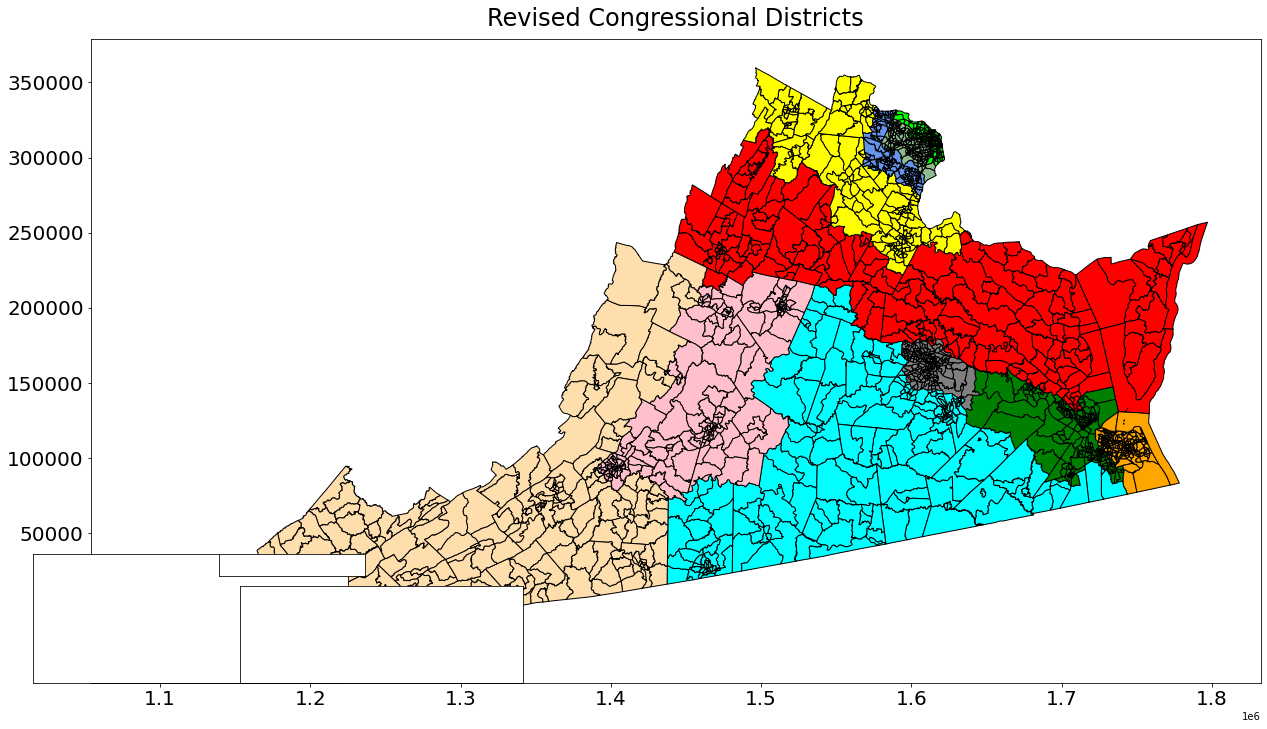

Done plotting and saving in 37 seconds!


In [95]:
s = time.time()
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "

alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = False

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    new_district_list = tract_gdf[(tract_gdf['STUSAB'] == this_state)]['new_district'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(new_district_list)+1):
        tract_gdf[
            (tract_gdf['STUSAB'] == this_state) 
            & (tract_gdf['new_district'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
    

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
#ax.legend(handles=legend_list, fontsize=10)

ax.set_title('Revised Congressional Districts', fontsize=24, y=1.01)

ax.tick_params(axis='both', labelsize=20)

# # # # # # print('saving figure...')
# # # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # # #plt.show()
# # # e = time.time()
# # # g += (e-s)
# # # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'AK')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(new_district_list)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'HI')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'HI') & (tract_gdf['new_district'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

### Check RI
# ax.set_xlim([1.9e6, 2.2e6])
# ax.set_ylim([.7e6, .9e6])

for thisax in [ak_inset_ax, aleutians_inset_ax, hi_inset_ax]: #[ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

plt.show()
# print('saving figure...')
# fig.savefig(script_dir+'new-districts-11.jpg', format='jpg', dpi=300, bbox_inches='tight')
e = time.time()
g += (e-s)
print('Done plotting and saving in {0:,.0f} seconds!'.format(e-s))


In [97]:
s = time.time()
tract_gdf['new_district'].to_csv(script_dir+'new-districts-11.csv')
e = time.time()
g += (e-s)
print('Classified and saved {0:,.0f} in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format( np.floor(g/60), g%60))

Classified and saved 2,198 in 0 minutes 0 seconds!


TOTAL TIME: 25 minutes 1 seconds!


# VIRGINIA

Assigning districts by place...
Accounting for known duplicate places...
	Belle Haven: Keeping GEOID = 1600000US5105928: overlaps 2 tracts containing 6,851 people!
	Rose Hill: Keeping GEOID = 1600000US5168880: overlaps 6 tracts containing 22,940 people!
	Woodlawn: Keeping GEOID = 1600000US5187410: overlaps 4 tracts containing 20,859 people!
	Wakefield: Keeping GEOID = 1600000US5182371: overlaps 3 tracts containing 14,689 people!
	Bull Run: Keeping GEOID = 1600000US5111230: overlaps 2 tracts containing 11,024 people!


checking for additional duplicate nanes...


Looking for tracts related to places in District 1...
Looking for tracts related to places in District 2...
	Tracts within District 2: 122...
	Tracts intersecting (but not within) District 2: 49...
		Examining tract 1 of 49...
Looking for tracts related to places in District 3...
	Tracts within District 3: 193...
	Tracts intersecting (but not within) District 3: 13...
		Examining tract 1 of 13...
Looking for tracts related to p

In [96]:
# s = time.time()
# this_state = 'VA'

# show_water = True
# label_tracts = False

# show_counties = False
# label_counties = False

# show_places = False
# label_places = False

# print_ready = False
# assign_to_district = 11

# the_label_size = 20
# the_annotation_size = 18
# #the_annotation_size_big = 28
# the_line_width = .5
# the_line_width_wide = 4
# the_legend_size = 18
# the_title_size = 28

# bounds_counties = []

# if (len(bounds_counties) > 0):
#     xlimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[3]]
# else:
#     xlimits = [unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[3]]


# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

# print('xspan = {0:,.2f} km'.format(xspan / 1000))
# print('yspan = {0:,.2f} km'.format(yspan / 1000))
# print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
# print('\n')


# # fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
# fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
# ax.set_aspect('equal')

# print('plotting tracts...')
# # base layer
# legend_list = []
# for i in range(-1,these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
#         tract_gdf[(tract_gdf['new_district'] == i)].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

# #tract_gdf[(tract_gdf['new_district'].isnull())].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', lw=the_line_width)


# if (show_counties):
#     print('plotting state and county borders...')
#     if (len(bounds_counties) > 0):   
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     else:
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width)

# if (label_counties):
#     print('labeling counties...')
#     if (len(bounds_counties) > 0):
#         counties_to_label = bounds_counties
#     else:
#         counties_to_label = county_gdf[county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]]['NAME'].tolist()
#     for ix, thisrow in county_gdf[
#         (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (county_gdf['NAME'].isin(counties_to_label))
# #         & ( 
# #             ((county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x) >= xlimits[0]) & (county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
# #             & ((county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y) >= xlimits[0]) & (county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y) <= xlimits[1]))
# #         )        
#     ].to_crs(main_map_crs).iterrows():
#         ax.annotate('{0:}'.format(thisrow['NAMELSAD'].replace(' ','\n')), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), color='black', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size)


# if (show_places):
#     print('plotting places...')
#     place_gdf.to_crs(main_map_crs).plot(ax=ax, edgecolor='purple', lw=the_line_width_wide, color='none')
    
# if (label_places):
#     print('\tlabeling places...')
#     for ix, thisrow in geopandas.overlay(
#         place_gdf.reset_index().to_crs(main_map_crs),
#         geopandas.GeoDataFrame(data=[[box(xlimits[0], ylimits[0], xlimits[1], ylimits[1])]], columns=['geometry'], crs=main_map_crs, geometry='geometry'),
#         how='intersection').set_index('GEOID').iterrows():
#             if (thisrow['NAME'] not in []):
#                 annotator = thisrow['NAME'].replace(' ', '\n')
#                 centerpoint = thisrow.geometry.centroid.coords[0]
#                 ax.annotate(annotator, centerpoint, color='purple', ha='center', va='center', fontsize=the_annotation_size, bbox=dict(facecolor='white', edgecolor='black', pad=4))

# if (show_water):
#     print('plotting water areas...')
#     water_gdf.to_crs(main_map_crs).plot(ax=ax, color='blue')#, alpha=0.5)

# if (label_tracts):
#     print('\tlabeling tracts...')
#     for ix, thisrow in geopandas.overlay(
#         tract_gdf[
#             #(tract_gdf['new_district'].isnull())
#             (tract_gdf['new_district'] == 5)
#         ].reset_index().to_crs(main_map_crs),
#         geopandas.GeoDataFrame(data=[[box(xlimits[0], ylimits[0], xlimits[1], ylimits[1])]], columns=['geometry'], crs=main_map_crs, geometry='geometry'),
#         how='intersection').set_index('GEOID').iterrows():
#             print('\t{0:}-{1:}: {2:}'.format(thisrow['COUNTY_NAME'][0:3], thisrow['census_tract'], ix))
#             annotator = '{0:}\n({1:,.0f})'.format(thisrow['census_tract'], thisrow['POP100'])
#             centerpoint = thisrow.geometry.centroid.coords[0]
#             ax.annotate(annotator, centerpoint, color='black', ha='center', va='center', fontsize=the_annotation_size, bbox=dict(facecolor='white', edgecolor='black', pad=4))
    
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# ax.tick_params(axis='both', labelsize=20, labelbottom=True, labeltop=True, labelleft=True, labelright=True)

# # nticks = 10
# # ax.set_xticks(np.arange(xlimits[0], xlimits[1], (xlimits[1]-xlimits[0])/nticks))
# # ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))

# # ax.set_yticks(np.arange(ylimits[0], ylimits[1], (ylimits[1]-ylimits[0])/nticks))
# # ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

# # ax.xaxis.set_tick_params(labelbottom=True, labeltop=True, labelsize=the_label_size, length=10, width=4, left=True, right=True)
# # ax.yaxis.set_tick_params(labelleft=True, labelright=True, labelsize=the_label_size, length=10, width=4, top=True, bottom=True)

# #ax.legend(handles=legend_list, fontsize=the_legend_size, loc='lower left')



# if (len(list(these_states_dict.keys())) == 1):
#     plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
#         list(these_states_dict.keys())[0], 
#         these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
#     ), fontsize=the_title_size)
# else:    
#     plt.title('New Congressional Districts', fontsize=the_title_size)

# print('\n')    
# for i in range(1, these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         #if (np.abs(1-(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target)) > 0.01):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

# e = time.time()
# g += (e-s)

# print('Plotted in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
        
# plt.show()




In [68]:

# 	NAME	POP100
# GEOID		
# 47900	Washington-Arlington-Alexandria, DC-VA-MD-WV	3077537.0
# 47260	Virginia Beach-Norfolk-Newport News, VA-NC	1750741.0
# 40060	Richmond, VA	1314434.0
# 40220	Roanoke, VA	315251.0
# 31340	Lynchburg, VA	261593.0
# 16820	Charlottesville, VA	221524.0
# 13980	Blacksburg-Christiansburg, VA	166378.0
# 25500	Harrisonburg, VA	135571.0
# 44420	Staunton, VA	125433.0
# 49020	Winchester, VA-WV	119539.0
# 19260	Danville, VA	103091.0
# 28700	Kingsport-Bristol, TN-VA	92730.0
# 32300	Martinsville, VA	64433.0

In [22]:
######## VIRGINIA ##########

### DC Area
# xlimits = [1.56e6,1.64e6]
# ylimits = [270000,340000]

# Alexandria/Arlington
# xlimits = [1.58e6,1.62e6]
# ylimits = [295000,335000]


## # Virginia Beach area
# xlimits = [1.675e6,1.765e6]
# ylimits = [70000,140000]


## # Chesapeake City area
# xlimits = [1.724e6,1.748e6]
# ylimits = [78000,110000]


## # Chesapeake City / Portsmouth City
# places_to_show = ['Chesapeake', 'Portsmouth']
# xlimits = [unary_union(place_gdf[place_gdf['NAME'].isin(places_to_show)].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(place_gdf[place_gdf['NAME'].isin(places_to_show)].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
# ylimits = [unary_union(place_gdf[place_gdf['NAME'].isin(places_to_show)].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(place_gdf[place_gdf['NAME'].isin(places_to_show)].to_crs(main_map_crs).geometry.tolist()).bounds[3]]


## # York Peninsula (Newport News)
# xlimits = [1.65e6, 1.72e6]
# ylimits = [110000, 160000]

#### Southeast Virginia
# xlimits = [1.6e6,1.75e6]
# ylimits = [80000,160000]


# # #### Richmond outlying area
# xlimits = [1.5e6,1.7e6]
# ylimits = [100000,200000]

# #### Richmond City
# xlimits = [1.59e6,1.65e6]
# ylimits = [145000,180000]



### NW Chesterfield County
# xlimits = [1.5925e6,1.615e6]
# ylimits = [135000,160000]


